## simple debug setup

In [2]:
import os, osr, glob
import xarray as xr
import rioxarray
from rioxarray.merge import merge_datasets, merge_arrays
import numpy as np
import geopandas as gpd
#
from geocube.api import core
#
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
#
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
#
import seaborn as sns
#
from equi7grid.equi7grid import Equi7Grid
#%matplotlib widget
#%matplotlib inline

# my tools:
from auxilary_annalysis_mm import multivarFit_s1_forAge

Set the tile, orbit, and polarisation to read:

In [3]:
#myTile = 'E066N060T3' # Rondonia
#myOrbit = 'D156' # Rondonia
#
myTile = 'E078N066T3' # Para
myOrbit = 'D039' # Para
#
myPol = 'VH'

In [4]:
# set the folter wih the output files:
data_folder = r'/project/return/Share/mm/S1_SA_TEST_UPSCALE/' +  myTile + '_smallChanks'

In [5]:
# Equi7 SA wkt:
PROJ = 'PROJCS["Azimuthal_Equidistant",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["false_easting",7257179.23559],PARAMETER["false_northing",5592024.44605],PARAMETER["central_meridian",-60.5],PARAMETER["latitude_of_origin",-14.0],UNIT["Meter",1.0]]'

In [48]:
# read multiple ckunks:
ChunkDatasetList = []
# set the rwos and columns:
#myCols, myRows = np.meshgrid(np.arange(34, 38), np.arange(42, 46)) # Rondonia
myCols, myRows = np.meshgrid(np.arange(20, 26), np.arange(38, 44)) # Para
# read each one
for myRow, myCol in zip(myRows.flatten(), myCols.flatten()):
    # set filename:
    fileName = myTile + '_' + str(myRow) + '_' + str(myCol) + '_250_' + myOrbit + '_'+ myPol + '.nc'
    aux_ds = rioxarray.open_rasterio(os.path.join(data_folder, fileName))
    # set crs:
    aux_ds.rio.write_crs(PROJ, inplace=True)
    ChunkDatasetList.append(aux_ds)      

In [49]:
# mearge chanks spatialy:
my_out = merge_datasets(ChunkDatasetList)   

In [50]:
my_out

<xarray.Dataset>
Dimensions:           (band: 1, y: 1500, x: 1500)
Coordinates:
  * band              (band) int64 1
  * x                 (x) float64 7.9e+06 7.9e+06 7.9e+06 ... 7.93e+06 7.93e+06
  * y                 (y) float64 6.71e+06 6.71e+06 ... 6.68e+06 6.68e+06
    spatial_ref       int64 0
Data variables: (12/73)
    exception_label   (band, y, x) float64 0.0 2.0 0.0 0.0 ... nan nan nan nan
    max_mag           (band, y, x) float64 2.91 nan 3.673 3.599 ... nan nan nan
    max_mag_date      (band, y, x) float64 2.021e+03 nan 2.021e+03 ... nan nan
    t_pre             (band, y, x) float64 -1.0 nan -37.0 -37.0 ... nan nan nan
    t_post            (band, y, x) float64 5.0 nan 35.0 78.0 ... nan nan nan nan
    t_total           (band, y, x) float64 305.0 nan 78.0 390.0 ... nan nan nan
    ...                ...
    MAD_2017          (band, y, x) float64 0.8 1.3 1.4 1.4 ... nan nan nan nan
    MAD_2018          (band, y, x) float64 1.0 1.2 1.4 1.0 ... nan nan nan nan
    MAD_2019          (band, y, x) float64 1.1 1.0 1.3 1.2 ... nan nan nan nan
    MAD_2020          (band, y, x) float64 1.35 1.65 1.6 1.35 ... nan nan nan
    seg_id            (band, y, x) float64 -1.0 0.0 0.0 1.0 ... nan nan nan nan
    seg_size          (band, y, x) float64 24.0 nan 144.0 234.0 ... nan nan nan

Read forest age and LULC data:

In [51]:
# fileName2 = r'myforAgeLCLU_2017_2020_equi7_E066N060T3_20m.tif' # Rondonia
fileName2 = r'myforAgeLCLU_2017_2020_equi7_E078N066T3_20m.tif' # Para
forAgeLULC = rioxarray.open_rasterio(fileName2, band_as_variable=True)
# convert to dataset:
forAgeLULC_ds = forAgeLULC.to_dataset('band').rename({1: 'forAge2017', 2: 'lulc2018', 3: 'lulc2019', 4: 'forAge2020', 5: 'ECO_ID'})

Correct coordinates (temporary soluton!!!)

In [52]:
forAgeLULC_ds = forAgeLULC_ds.assign_coords(x=forAgeLULC_ds.x - 10 )

In [53]:
forAgeLULC_ds = forAgeLULC_ds.assign_coords(y=forAgeLULC_ds.y + 10 )

Join datasets and clip forAgeLCLU to my_out coordinates:

In [54]:
all_ds = xr.merge([my_out.isel(band=0, drop=True), forAgeLULC_ds], join='inner') 

## Add annual statistics

In [55]:
# Add the combined annual statistics:
all_ds['qDiff_2017'] = all_ds['q90_2017'] - all_ds['q10_2017']
all_ds['dRange_2017'] = all_ds['max_2017'] - all_ds['min_2017']
all_ds['iqRange_2017'] = all_ds['q75_2017'] - all_ds['q25_2017']

In [56]:
# set the relevant statistics:
myStatnames = ['mean_2017', 'median_2017', 'std_2017', 'MAD_2017', 'dRange_2017', 'qDiff_2017', 'iqRange_2017', 'forAge2017']
# mearge the arrays into new dataset:
my_ds = all_ds[myStatnames]

In [57]:
#my_ds.isel(x=np.arange(200), y=np.arange(200))

In [58]:
np.arange(250, my_ds.mean_2017.shape[0] + 250, 250)

array([ 250,  500,  750, 1000, 1250, 1500])

## Fit a model :

In [59]:
model_score = multivarFit_s1_forAge(my_ds)

In [60]:
model_score

0.8647961606436693

In [61]:
# specify step in pixels
myStep = 100
# specifiy maximum pixel index:
myMaxPixs = np.arange(myStep, my_ds.mean_2017.shape[0] + myStep, myStep)
# initate an empty list for storing r2
myR2 = []
# loop trough different sizes
for pixNum in myMaxPixs:
    aux_ds = my_ds.isel(x=np.arange(0, pixNum), y=np.arange(0, pixNum)) 
    myR2.append(multivarFit_s1_forAge(aux_ds))

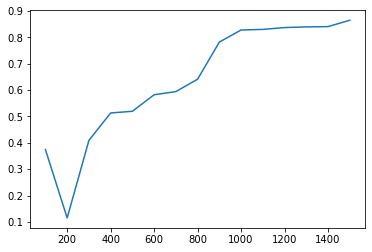

In [62]:
plt.plot(myMaxPixs, myR2)